In [1]:
import gc
import tensorflow as tf
print('Teorflow version: {}'.format(tf.__version__))
print('Keras version: {}'.format(tf.keras.__version__))

Teorflow version: 2.3.3
Keras version: 2.4.0


In [2]:
## get label and list sample test processed dataset to testing
import os
import time

var_dir = r'1_datasets/processed_dataset/val'
test_dir = r'1_datasets/processed_dataset/test'

# get labels
labels = sorted(os.listdir(test_dir))
print('Labels of datasets: {}\n'.format(labels))

# get list sample
import pandas as pd
from tqdm import tqdm

def get_samples(folder=''):
    list_sample = []
    for label in os.listdir(folder):
        label_dir = os.path.join(folder, label)
        for file in tqdm(os.listdir(label_dir)):
            file_path = os.path.join(label_dir, file)
            file_path = file_path.replace('\\', '/')
            list_sample.append([file_path, label])
    return pd.DataFrame(list_sample, columns=['image', 'label'])


def log_title(title=""):
    title = ' {}'.format(title.upper()).rjust(100, '=')
    title += '\n' + '=' * 100 + '\n'
    print(title)
    
    
## get sample data validation
log_title('Get validation set')
val_set = get_samples(var_dir)
print(val_set)


## get sample data test
log_title('Get test set')
test_set = get_samples(test_dir)
print(test_set)

  0%|                                                                                          | 0/500 [00:00<?, ?it/s]

Labels of datasets: ['ArtDecor', 'Hitech', 'Indochina', 'Industrial', 'Scandinavian']

================================================================================= GET VALIDATION SET

                                                  image         label
0     1_datasets/processed_dataset/val/ArtDecor/ArtD...      ArtDecor
1     1_datasets/processed_dataset/val/ArtDecor/ArtD...      ArtDecor
2     1_datasets/processed_dataset/val/ArtDecor/ArtD...      ArtDecor
3     1_datasets/processed_dataset/val/ArtDecor/ArtD...      ArtDecor
4     1_datasets/processed_dataset/val/ArtDecor/ArtD...      ArtDecor
...                                                 ...           ...
1925  1_datasets/processed_dataset/val/Scandinavian/...  Scandinavian
1926  1_datasets/processed_dataset/val/Scandinavian/...  Scandinavian
1927  1_datasets/processed_dataset/val/Scandinavian/...  Scandinavian
1928  1_datasets/processed_dataset/val/Scandinavian/...  Scandinavian
1929  1_datasets/processed_dataset/val/Sc

100%|█████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 83551.87it/s]

                                                  image         label
0     1_datasets/processed_dataset/test/ArtDecor/Art...      ArtDecor
1     1_datasets/processed_dataset/test/ArtDecor/Art...      ArtDecor
2     1_datasets/processed_dataset/test/ArtDecor/Art...      ArtDecor
3     1_datasets/processed_dataset/test/ArtDecor/Art...      ArtDecor
4     1_datasets/processed_dataset/test/ArtDecor/Art...      ArtDecor
...                                                 ...           ...
2495  1_datasets/processed_dataset/test/Scandinavian...  Scandinavian
2496  1_datasets/processed_dataset/test/Scandinavian...  Scandinavian
2497  1_datasets/processed_dataset/test/Scandinavian...  Scandinavian
2498  1_datasets/processed_dataset/test/Scandinavian...  Scandinavian
2499  1_datasets/processed_dataset/test/Scandinavian...  Scandinavian

[2500 rows x 2 columns]


In [3]:
## random choise 1 sample
def get_example(setSample, noExample=1):    
    return setSample.sample(n=noExample).reset_index(drop=True)
def show_sample(image, title=None):
    plt.figure(figsize=(5, 5))
    if title:
        plt.title(title)
    plt.imshow(image)
    plt.show()

                                               image         label
0  1_datasets/processed_dataset/test/Scandinavian...  Scandinavian
Found 1 validated image filenames belonging to 1 classes.
(1, 224, 224, 3)


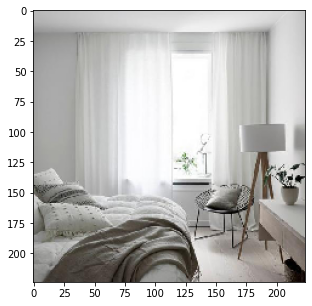

In [4]:
## show sample to predict
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

example_df = test_set.sample(n=1).reset_index(drop=True) # get a sample

print(example_df)

## data processing (convert to array and normalize) before prediction [Methob 1]
# use funtion ImageDataGenerator to generate image array
test_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = test_datagen.flow_from_dataframe(dataframe=example_df, # sample to predict
                                            directory='',
                                            x_col="image",
                                            y_col="label",
                                            class_mode="categorical", 
                                            target_size=(224, 224),
                                            shuffle=False)
print(test_datagen.next()[0].shape)
show_sample(test_datagen.next()[0][0])

In [5]:
## data processing (convert to array and normalize) before prediction [Methob 2]
import cv2
import numpy as np

def resize_image(path, target_size=224):
    img_arr = cv2.imread(path, cv2.IMREAD_COLOR)
    img_arr = cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB)
    img_arr = cv2.resize(img_arr, 
                         (target_size, target_size), 
                         interpolation=cv2.INTER_CUBIC) # Reshaping images to preferred size
    img_arr = img_arr.reshape(-1, target_size, target_size, 3).astype(np.float32)
    img_arr = img_arr / 255
    return img_arr

(1, 224, 224, 3)


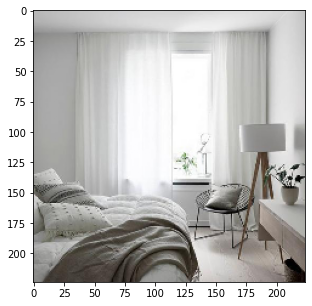

In [6]:
image = resize_image(example_df.iloc[0].image)
print(image.shape)
show_sample(image[0])

In [5]:
## Api can be use url to predict
import time
from skimage import io

def get_image_from_url(url):
    return io.imread(url)

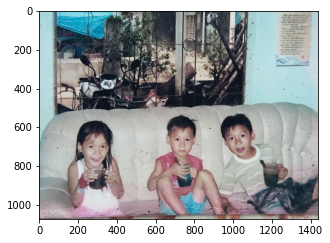

In [8]:
image_url=r'https://firebasestorage.googleapis.com/v0/b/interior-design-afc76.appspot.com/o/posts%2F2lSrBPikLrdR0JwHKj5g%2F138569823_503848043925554_660635631499600523_n.jpg?alt=media&token=66e6afcf-2e23-4021-a90c-b34e1eb56cc9'
image = get_image_from_url(image_url)
# print('Photo download time: {}s'.format(str(round(end_time, 2))))
show_sample(image)

In [9]:
## load all available keras model
import time
from tqdm import tqdm
from tensorflow.keras.models import load_model

def load_keras_models(models_dir=''):
    models = dict({})
    
    for model in [item for item in os.listdir(models_dir) if '.h5' in item]:
        # get model name
        model_name = model.split('.')[0]
        # get model path
        model_path = os.path.join(models_dir, model)
        # load model
        start_time = time.time()
        models[model_name] = load_model(model_path)
        end_time = time.time() - start_time
        # show message successfully
        print('Load model {} successfully in {}s!'.format(model_name, round(end_time, 2)))
        
    # return results
    return models

def load_tflite_models(models_dir=''):
    models = dict({})
    
    for model in [item for item in os.listdir(models_dir) if '.tflite' in item]:
        # get model name
        model_name = model.split('.')[0]
        # get model path
        model_path = os.path.join(models_dir, model)
        # load model
        start_time = time.time()
        model = tf.lite.Interpreter(model_path=model_path)
        model.allocate_tensors()
        models[model_name] = model
        end_time = time.time() - start_time
        # show message successfully
        print('Load model {} successfully in {}s!'.format(model_name, round(end_time, 2)))
    # return results
    return models

In [10]:
models_tflite_default = load_tflite_models('3_models/models_tflite_default')

Load model DenseNet201 successfully in 0.02s!
Load model InceptionV3 successfully in 0.02s!
Load model Model1 successfully in 0.0s!
Load model Model2 successfully in 0.02s!
Load model Xception successfully in 0.01s!


In [16]:
## show demo crop image
import os
import math
import random
import numpy as np
from os import path
from tqdm import tqdm
from PIL import Image, ImageOps
from matplotlib.pyplot import imshow
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
%matplotlib inline

target_size = 512

def get_image_from_url(url):
    return io.imread(url)

def gen_step(size, target_size): # size >= target_size
    frac, whole = math.modf(size / target_size) # get frac and whole
    if frac > 0.2: whole += 1 # if frac > 0.2 => increase whole
    # return result
    return int(whole)

def customize_size(original_size, target_size):
    ratio = 1
    width, height = original_size
    ratio = (width / target_size) if (width < height) else (height / target_size)    
    return int(width / ratio), int(height / ratio)

def crop_image(image, area):
    c_img = image.crop(area) # crop image with area
    # return with fit image
    return ImageOps.fit(c_img, (target_size, target_size), Image.ANTIALIAS)

def data_processing_for_api_demo(image_url, target_size=224):
    image = get_image_from_url(image_url)
    image = Image.fromarray(image.astype('uint8'), 'RGB')
    # get size to resize
    w, h = customize_size(image.size, target_size)

    # only for demo (original image)
    fig_size = (15, 5) if (w > h) else (5, 15)
    fig = plt.figure(figsize=fig_size)
    fig.add_subplot(1, 1, 1)
    plt.title( 'Orignal image ({}, {})'.format(image.size[0], image.size[1]))
    plt.imshow(image)

    # resize image
    image = image.resize((w, h))
    # get the number of images that can be taken in rows and columns
    noCol = gen_step(w, target_size)
    noRow = gen_step(h, target_size)

    # only for demo (resize image)
    fig = plt.figure(figsize=fig_size)
    fig.add_subplot(1, 1, 1)
    plt.title( 'Resize image ({}, {})'.format(w, h))
    plt.imshow(image)

    colors = ['g', 'b', 'w', 'y']

    if noCol==1 and noRow==1: # if can get only 1 image, crop the image in the center

        x_ = (w - target_size) // 2
        y_ = (h - target_size) // 2

        # only for demo (croped image in original image)
        currentAxis = plt.gca()
        currentAxis.add_patch(Rectangle((x_, y_), target_size, target_size, 
                                        fill=None, alpha=1, linestyle='-', color='r', linewidth=2))

        # crop image
        area = (x_, y_, x_ + target_size, y_ + target_size)
        croped_image = crop_image(image, area)

        # only for demo (croped image)
        fig = plt.figure(figsize=(5, 5))
        fig.add_subplot(1, 1, 1)
        plt.title( 'croped_image')
        plt.imshow(croped_image)
    else: # if can get multi image 
        # get step and position max for crop
        x_max, y_max = np.array((w, h)) - target_size # get max position
        # get step
        stepCol = (x_max // (noCol - 1)) if (noCol > 1) else 1
        stepRow = (y_max // (noRow - 1)) if (noRow > 1) else 1

        i = 1
        num_croped = noCol * noRow

        # setting values to rows and column variables
        rows = 1
        columns = noCol * noRow

        # only for demo (croped image in original image)
        index = 0
        currentAxis = plt.gca()
        for random_x in range(0, x_max+1, stepCol):
            for random_y in range(0, y_max+1, stepRow):
                currentAxis.add_patch(Rectangle((random_x, random_y), target_size, target_size, 
                                                fill=None, alpha=1, linestyle='-', color=colors[index], linewidth=2))
                index += 1

        # create figure (demo)
        fig = plt.figure(figsize=(5 * columns, 5))

        for random_x in range(0, x_max + 1, stepCol):
            for random_y in range(0, y_max + 1, stepRow):
                # crop image
                area = (random_x, random_y, random_x + target_size, random_y + target_size)
                croped_image = crop_image(image, area)

                # Adds a subplot
                fig.add_subplot(rows, columns, i)

                # only for demo (croped image)
                # plt.axis('off')
                plt.title( 'Croped image ' + str(i))
                plt.imshow(croped_image)

                i += 1

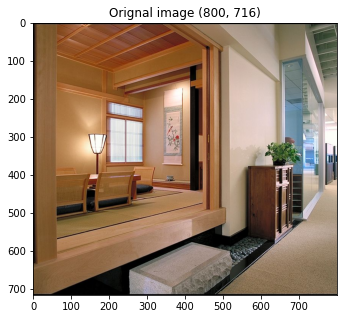

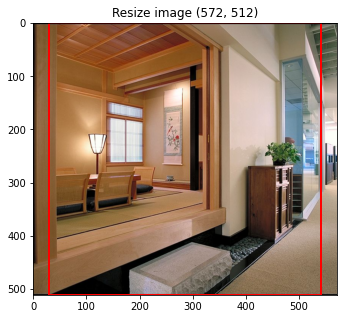

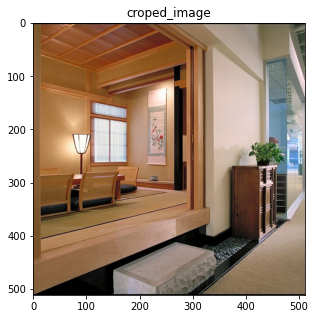

In [17]:
image_url=r'https://i.pinimg.com/originals/f6/c3/1e/f6c31e7f6608d5b49b2fb2cc369fa81e.jpg'
# image_url=r'https://i.pinimg.com/564x/20/44/6d/20446dee2d3ef28b880a2ab2a605bcb8.jpg'
# image_url=r'https://i.pinimg.com/originals/61/ef/93/61ef93c285c62426ab7072caad54b1c8.jpg'
data_processing_for_api_demo(image_url, target_size=512)

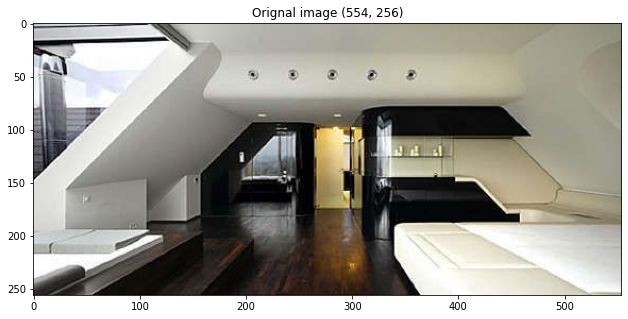

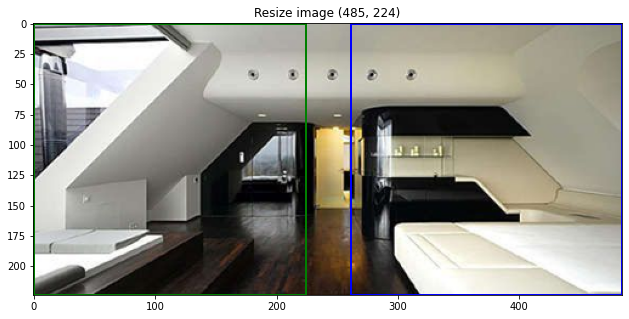

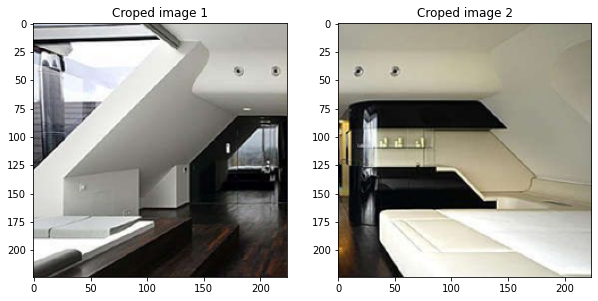

In [142]:
image_url=r'https://i.pinimg.com/564x/20/44/6d/20446dee2d3ef28b880a2ab2a605bcb8.jpg'
# image_url=r'https://i.pinimg.com/originals/61/ef/93/61ef93c285c62426ab7072caad54b1c8.jpg'
data_processing_for_api_demo(image_url)

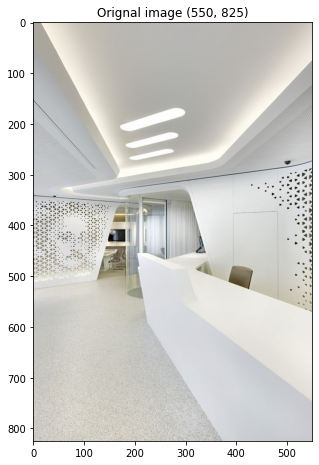

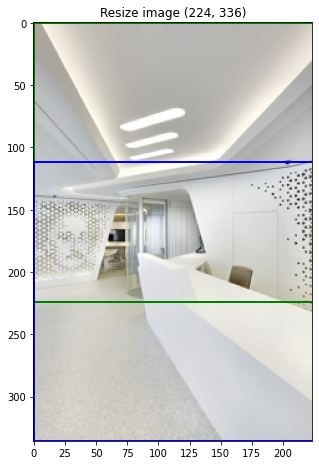

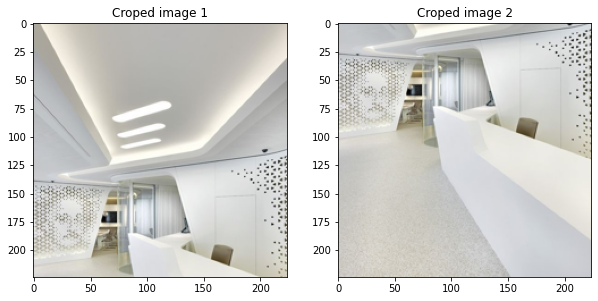

In [143]:
image_url=r'https://i.pinimg.com/originals/61/ef/93/61ef93c285c62426ab7072caad54b1c8.jpg'
data_processing_for_api_demo(image_url)

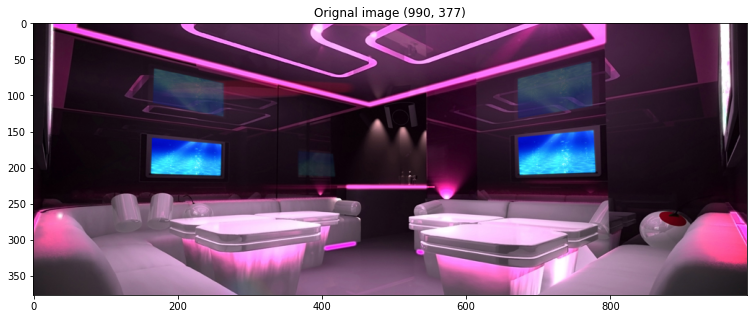

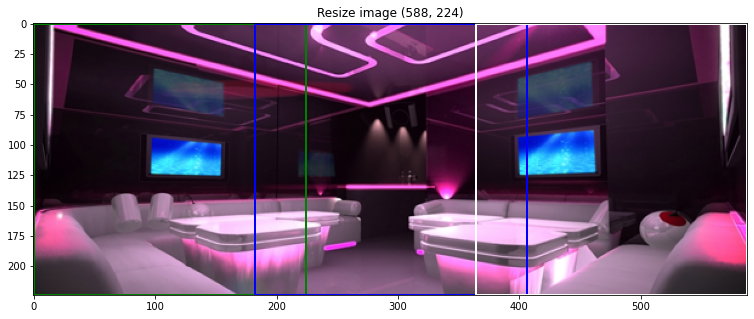

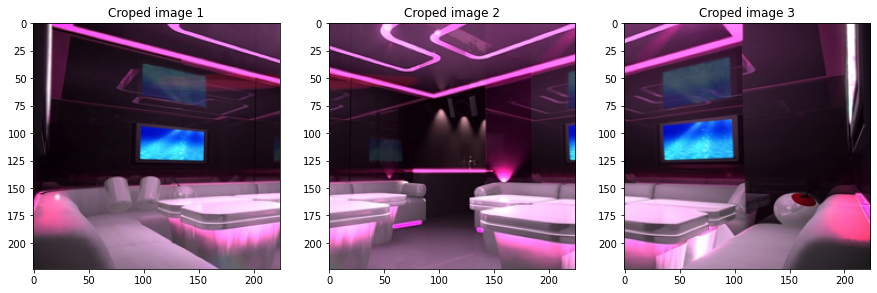

In [249]:
image_url=r'https://www.vimage.it/wp-content/uploads/2012/03/982102521.jpg'
data_processing_for_api_demo(image_url)

In [8]:
## show demo crop image
import os
import math
import random
import numpy as np
from os import path
from tqdm import tqdm
from PIL import Image, ImageOps
from matplotlib.pyplot import imshow
from matplotlib.patches import Rectangle
%matplotlib inline

def get_image_from_url(url):
    return io.imread(url)

def gen_step(size, target_size): # size >= target_size
    frac, whole = math.modf(size / target_size) # get frac and whole
    if frac > 0.2: whole += 1 # if frac > 0.2 => increase whole
    # return result
    return int(whole)

def crop_image(image, area):
    c_img = image.crop(area) # crop image with area
    # return with fit image
    return ImageOps.fit(c_img, (target_size, target_size), Image.ANTIALIAS)

def data_processing_for_api(image_url, target_size=224):
    # images
    images = np.empty((0, target_size, target_size, 3), dtype='float32')
    
    # get image
    image = get_image_from_url(image_url)
    image = Image.fromarray(image.astype('uint8'), 'RGB')
    
    # get size to resize
    w, h = customize_size(image.size, target_size)
    
    # resize image
    image = image.resize((w, h))
    # get the number of images that can be taken in rows and columns
    noCol = gen_step(w, target_size)
    noRow = gen_step(h, target_size)

    if noCol==1 and noRow==1: # if can get only 1 image, crop the image in the center

        # get position crop
        x_ = (w - target_size) // 2
        y_ = (h - target_size) // 2

        # crop image
        area = (x_, y_, x_ + target_size, y_ + target_size)
        croped_image = crop_image(image, area)
        croped_image = np.array(croped_image) / 255
        croped_image = croped_image.reshape(1, target_size, target_size, 3).astype(np.float32)
        
        # add to array
        images = np.append(images, croped_image, axis=0)

    else: # if can get multi image 
        # get step and position max for crop
        x_max, y_max = np.array((w, h)) - target_size # get max position
        # get step
        stepCol = (x_max // (noCol - 1)) if (noCol > 1) else 1
        stepRow = (y_max // (noRow - 1)) if (noRow > 1) else 1

        for random_x in range(0, x_max + 1, stepCol):
            for random_y in range(0, y_max + 1, stepRow):
                # crop image
                area = (random_x, random_y, random_x + target_size, random_y + target_size)
                croped_image = crop_image(image, area)
                croped_image = np.array(croped_image) / 255
                croped_image = croped_image.reshape(-1, target_size, target_size, 3).astype(np.float32)
                # add to array
                images = np.append(images, croped_image, axis=0)
                
    #return array
    return images

In [9]:
image_url=r'https://i.pinimg.com/originals/f6/c3/1e/f6c31e7f6608d5b49b2fb2cc369fa81e.jpg'
# image_url=r'https://i.pinimg.com/564x/20/44/6d/20446dee2d3ef28b880a2ab2a605bcb8.jpg'
# image_url=r'https://i.pinimg.com/originals/61/ef/93/61ef93c285c62426ab7072caad54b1c8.jpg'
images = data_processing_for_api(image_url, 512)
images.shape

NameError: name 'customize_size' is not defined

In [259]:
import time

start_time = time.time()

# image_url=r'https://i.pinimg.com/originals/f6/c3/1e/f6c31e7f6608d5b49b2fb2cc369fa81e.jpg'
# image_url=r'https://i.pinimg.com/564x/20/44/6d/20446dee2d3ef28b880a2ab2a605bcb8.jpg'
image_url=r'https://i.pinimg.com/originals/61/ef/93/61ef93c285c62426ab7072caad54b1c8.jpg'
# image_url=r'https://www.vimage.it/wp-content/uploads/2012/03/982102521.jpg'
images = data_processing_for_api(image_url)
# images = np.array(images)

model_ = models_tflite_default['InceptionV3']
input_details = model_.get_input_details()
output_details = model_.get_output_details()

noImage = len(images)
print(noImage)
if noImage != input_details[0]['shape'][0]:
    model_.resize_tensor_input(input_details[0]['index'], (noImage, target_size, target_size, 3))
    model_.resize_tensor_input(output_details[0]['index'], (noImage, 5))
    model_.allocate_tensors()

# input_details = model_.get_input_details()
# output_details = model_.get_output_details()
    
model_.set_tensor(input_details[0]['index'], images)
model_.invoke()
output = model_.get_tensor(output_details[0]['index'])
print(time.time() - start_time)
# classes = np.argmax(output, axis = 1)
np.round(output, 2)

2
2.5336687564849854


array([[0.  , 1.  , 0.  , 0.  , 0.  ],
       [0.  , 0.99, 0.  , 0.  , 0.01]], dtype=float32)

In [278]:
def soft_voting(output):
    return np.sum(output, axis=0) / len(output)

def predict(model, images):
    # get number of images
    noImage = len(images)
    
    # get input and output of interpreter
    input_details = model.get_input_details()
    output_details = model.get_output_details()

    # if input and output not map with input image => reshape
    if noImage != input_details[0]['shape'][0]:
        model.resize_tensor_input(input_details[0]['index'], 
                                  (noImage, target_size, target_size, 3))
        model.resize_tensor_input(output_details[0]['index'], 
                                  (noImage, 5))
        model.allocate_tensors()
    
    # set input images with input layer interpreter 
    # and get the result in the output layer
    model.set_tensor(input_details[0]['index'], images)
    model.invoke()
    output = model.get_tensor(output_details[0]['index'])
    
    # soft voting output
    output = soft_voting(output)
    
    # return result
    return output

In [262]:
start_time = time.time()

# image_url=r'https://i.pinimg.com/originals/f6/c3/1e/f6c31e7f6608d5b49b2fb2cc369fa81e.jpg'
# image_url=r'https://i.pinimg.com/564x/20/44/6d/20446dee2d3ef28b880a2ab2a605bcb8.jpg'
image_url=r'https://i.pinimg.com/originals/61/ef/93/61ef93c285c62426ab7072caad54b1c8.jpg'
# image_url=r'https://www.vimage.it/wp-content/uploads/2012/03/982102521.jpg'
images = data_processing_for_api(image_url)
print(len(images))

predictions = predict(models_tflite_default['InceptionV3'], images)

start_time = time.time() - start_time

print(start_time)
predictions

2
2.238795757293701


array([1.5225646e-04, 1.9922783e+00, 5.8347163e-05, 2.4618024e-05,
       7.4863089e-03], dtype=float32)

In [267]:
models_tflite_default

{'DenseNet201': <tensorflow.lite.python.interpreter.Interpreter at 0x1524e3d32b0>,
 'InceptionV3': <tensorflow.lite.python.interpreter.Interpreter at 0x1524e020970>,
 'Model1': <tensorflow.lite.python.interpreter.Interpreter at 0x1524e3d3280>,
 'Model2': <tensorflow.lite.python.interpreter.Interpreter at 0x15236ea1280>,
 'Xception': <tensorflow.lite.python.interpreter.Interpreter at 0x15236ea14f0>}

In [279]:
# image_url=r'https://i.pinimg.com/originals/f6/c3/1e/f6c31e7f6608d5b49b2fb2cc369fa81e.jpg'
# image_url=r'https://i.pinimg.com/564x/20/44/6d/20446dee2d3ef28b880a2ab2a605bcb8.jpg'
image_url=r'https://i.pinimg.com/originals/61/ef/93/61ef93c285c62426ab7072caad54b1c8.jpg'
# image_url=r'https://www.vimage.it/wp-content/uploads/2012/03/982102521.jpg'
images = data_processing_for_api(image_url)
print(len(images))

for model_name in models_tflite_default:
#     if('Model' not in model_name):
    start_time = time.time()

    predictions = predict(models_tflite_default[model_name], images)

    start_time = time.time() - start_time

    print(start_time)
    print(np.round(predictions), 2)

2
3.4171142578125
[0. 1. 0. 0. 0.] 2
1.6978514194488525
[0. 1. 0. 0. 0.] 2
10.029979467391968
[0. 1. 0. 0. 0.] 2
0.39894556999206543
[0. 1. 0. 0. 0.] 2
3.50588321685791
[0. 1. 0. 0. 0.] 2


In [292]:
def ensemble_predict(images):
    predictions = []
    for model_name in models_tflite_default:
        start_time = time.time()
        prediction = predict(models_tflite_default[model_name], images)
        start_time = time.time() - start_time
        
        print(start_time)
        print(np.round(prediction), 2)
        predictions.append(prediction)
        
    print(predictions)
    return predictions
predictions = ensemble_predict(images)

4.245670557022095
[0. 1. 0. 0. 0.] 2
1.7033846378326416
[0. 1. 0. 0. 0.] 2
9.929527044296265
[0. 1. 0. 0. 0.] 2
0.4209010601043701
[0. 1. 0. 0. 0.] 2
3.796581745147705
[0. 1. 0. 0. 0.] 2
[array([1.8523185e-04, 9.7996658e-01, 1.4604229e-04, 1.9222133e-02,
       4.8002834e-04], dtype=float32), array([7.6128228e-05, 9.9613917e-01, 2.9173581e-05, 1.2309012e-05,
       3.7431545e-03], dtype=float32), array([0.00641493, 0.8668418 , 0.00094652, 0.01007395, 0.11572284],
      dtype=float32), array([6.6736480e-03, 8.7352848e-01, 1.6985551e-04, 1.5011143e-05,
       1.1961293e-01], dtype=float32), array([1.8157538e-04, 9.9809700e-01, 2.5957957e-04, 4.7877973e-05,
       1.4139998e-03], dtype=float32)]


In [296]:
np.round(soft_voting(predictions), 2)

array([0.  , 0.94, 0.  , 0.01, 0.05], dtype=float32)